<a href="https://colab.research.google.com/github/alexgaue/micrograd/blob/main/autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Backpropagation with Micrograd

But what exactly is a derivative? Let's look at a simple function with one input:

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

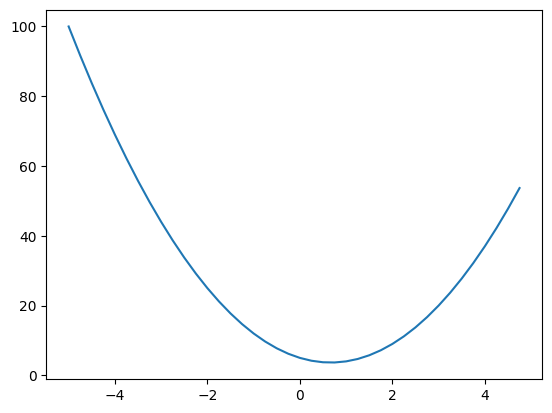

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Definition of the derivative: $\lim_{{h \to 0}} \frac{f(x + h) - f(x)}{h}$

In [ ]:
h = 0.000001 # an approximation
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

Let's look at a more complex case -- a function with multiple inputs -- to understand partial derivatives:

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


Let's build some data structures to help us visualize the math behind neural networks, using what we'll call the `Value` object, which just wraps a scalar value:

In [ ]:
class Value():

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    # topological order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # go one variable at a time and apply the chain rule to get its gradient
    self.grad = 1.0
    for v in reversed(topo):
      v._backward()

  def __neg__(self): # -self
    return self * -1

  def __radd__(self, other): # other + self
    return self + other

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1

  def __repr__(self):
    return f"Value(data={self.data})"

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

This data structure allows us to keep track of how each `Value` came to be (from what operation and from what other `Value`s). For a way to nicely visualize these relationships, we can also use a tree diagram:

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

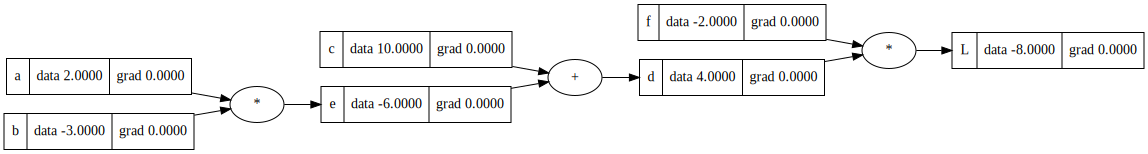

In [ ]:
draw_dot(L)

Here, we visualize the forward pass of input `Value`s to produce a single output `Value`, called $L$ or the Loss. `grad` represents the derivative of $L$ with respect to the current `Value`, e.g. `e.grad` represents the derivative $\frac{\partial L}{\partial e}$ (the amount of change $L$ experiences due to a small change in $e$). This is calculated using an application of the chain rule, since $\frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e}$, and we know $\frac{\partial L}{\partial d}$ (from `d.grad`) and can locally calculate $\frac{\partial d}{\partial e}$.

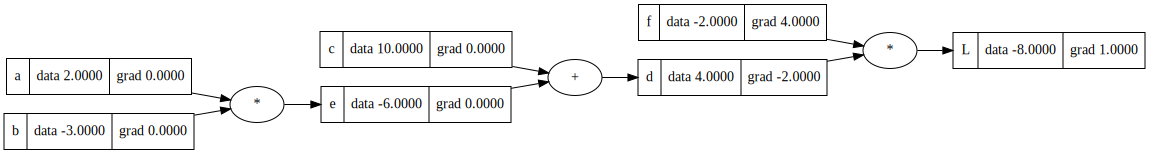

In [ ]:
L.grad = 1.0 # since dL/dL is 1.0
L._backward()
draw_dot(L)

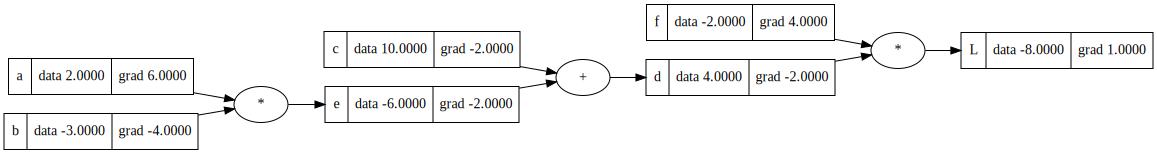

In [ ]:
d._backward()
e._backward()
draw_dot(L)

Note: we could've called backward on the leaves a, b, c, and f, but this is not necessary as their backward function is defined as `None`.

Let' s do an example with a neural net:

We can implement tanh() function in our Value object

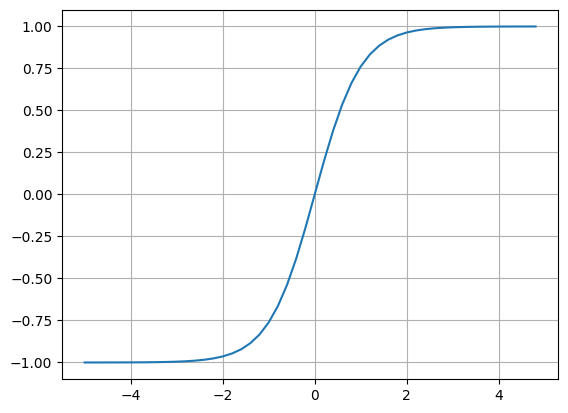

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid();

This time we will implement a single function to implement backpropagation, so we dont need to call it on each individual Value node. Topological sort allows us to implement the backward function for a whole expression graph, recursively

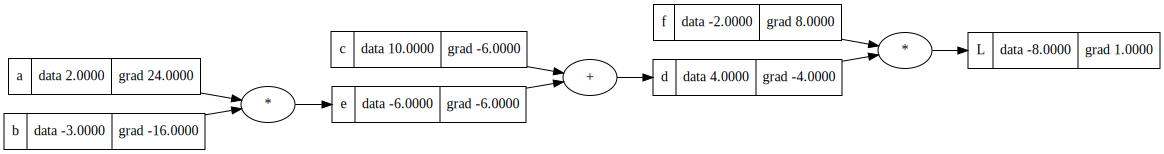

In [ ]:
L.backward()
draw_dot(L)

*** but do above with neural net example ***

In [ ]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

Now let's do the exact same thing, using a modern deep neural network library like PyTorch:

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


PyTorch is based around Tensors, which are just n-dimensional arrays of scalars. Cast to double() so that data values are type float64 like in python (they are float32 by default).

Now that we have machinery to build out complicated mathematical expressions, we can also start building up neural nets (which are just a specific class of mathematical expressions):

In [ ]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    return act.tanh()

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # allows layer with single value (e.g. output layer) to not have list format

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1])
model(x)

Value(data=0.8212158353332404)

We should able to `draw_dot` of model(x) (an entire MLP!), and as you might imagine, these expressions are now getting quite complicated:

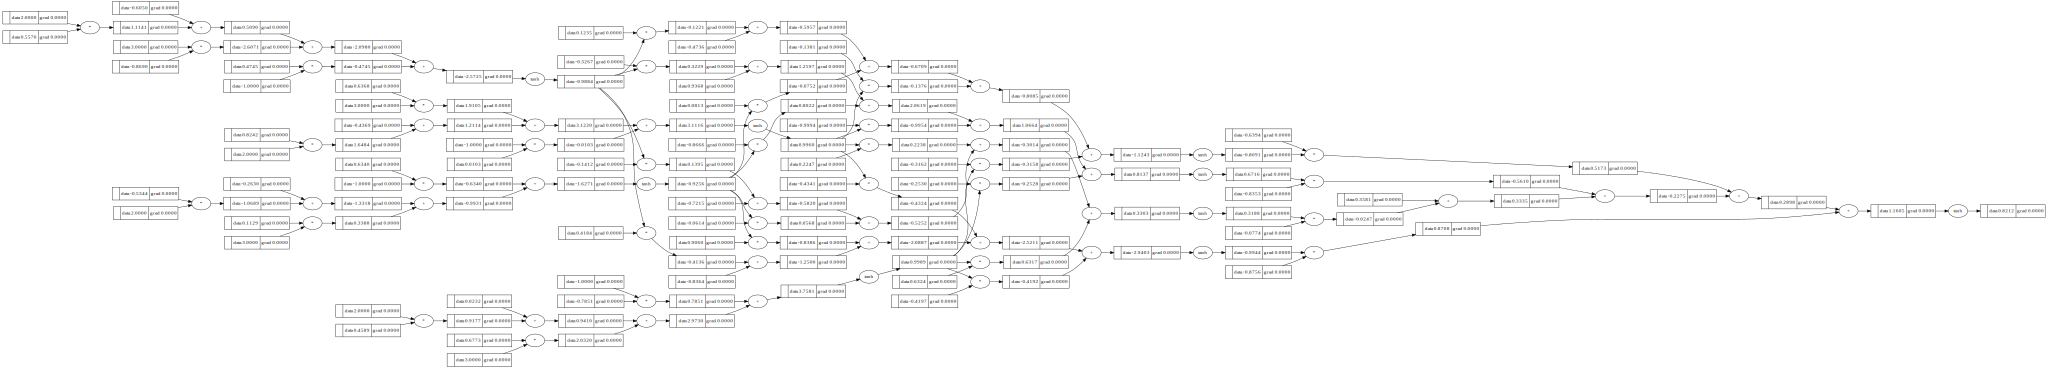

In [ ]:
draw_dot(model(x))

We should be able to backpropagate all the way through this complicated expression tree, something you would never differentiate manually on pen and paper. Here is a very simple binary classifier we will implement, with 4 examples, where we want the first and last to output 1 and the middle two to output -1.

In [ ]:
# data definitions
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

These are the outputs of our current neural net (a MLP that takes 3 inputs, 4 hidden neurons in two layers, and 1 output) on those 4 examples. How do we tune the weights of our net to better predict the desired targets? The trick is to evaluate our net using a function, called the loss function. In this case, we use the MSE (mean-squared error) loss. Now, we want to minimize the loss:

In [ ]:
for k in range(20):

  # forward pass
  ypred = [model(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in model.parameters():
    p.grad = 0.0
  loss.backward()

  # update (gradient descent)
  for p in model.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 6.819542256341681
1 5.543285859025342
2 2.937581299951106
3 1.818484983459772
4 1.059403968536389
5 0.6266055905365614
6 0.4034726937679707
7 0.28121786623122885
8 0.2086645238211975
9 0.16249020604659495
10 0.1312713664000811
11 0.10909438786791763
12 0.09269842620766702
13 0.08017665180478575
14 0.07035530376738901
15 0.06247936769955684
16 0.056044570287159604
17 0.05070306290316321
18 0.046208122778031796
19 0.04238046700773605


In [ ]:
ypred

[Value(data=0.9380214267393888),
 Value(data=-0.9024545906953414),
 Value(data=-0.8913372850509467),
 Value(data=0.8687886019897566)]

So, what are neural nets? Neural nets are mathematical expressions -- fairly simple mathematical expressions -- that take input as the data and they take input the weights and bias of the neural net. We calculate the loss (the accuracy) using a forward pass of the net, then we backward the loss -- use backpropagation to get the gradient -- and then we know how to tune all the parameters to decrease the loss locally. Iterating this process many times (or gradient descent) -- following the gradient information -- minimizes the loss.